# To be able to see visualizations in this notebook, please follow this [link](http://nbviewer.jupyter.org/github/antonino-barbera/seanbi/blob/master/project/project.ipynb?flush_cache=true)

# Data Collection

We will analyse data which comprise detail information on almost 3 million U.S. patents granted between January 1963 and December 1999. The patent dataset is maintained by the National Bureau of Economic Research (NBER). We downloaded them at the following link: http://www.nber.org/patents/

The data are in 5 zipped ASCII CSV files as follows:

* Pat63_99.zip contains the patent data, including the constructed variables
* Coname.zip contains the assignee names.
* Match.zip contains the match to CUSIP numbers
* Inventor.zip contains the individual inventor records
* Cite75_99.zip contains the pairwise citations data, between 1975 and 1999.

Each of these files has a corresponding "txt" file that contains the variable names and other documentation.

These data are described in detail in NBER Working Paper No. XXXX, "The NBER Patent Citations Data File:  Lessons, Insights and Methodological Tools," by Bronwyn H. Hall, Adam B. Jaffe and Manuel Trajtenberg.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sbn
import folium
import json
import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import networkx as nx
init_notebook_mode(connected=True)

### Pat63_99 file

In [58]:
df = pd.read_csv('data/apat63_99.csv')
print ("lenght: ",len(df))
df.head()

lenght:  2923922


,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,...,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Pat63_99 file is sorted by ascending patent number. <br>
There are 23 variables, which represent the following characteristics:
------------------

    patent: Patent Number
    gyear: Grant Year
    gdate: Grant Date
    appyear: Application Year
    country: Country of First Inventor
    postate: State of First Inventor (if US)
    assignee: Assignee Identifier (missing 1963-1967)
    asscode: Assignee Type
    claims: number of Claims
    nclass: Main Patent Class (3 digit)
    cat: Technological Category
    subcat: Technological Sub-Category
    cmade: Number of Citations Made
    creceive: Number of Citations Received
    ratiocit: Percent of Citations Made to Patents Granted Since 1963
    general: Measure of Generality
    original: Measure of Originality
    fwdaplag: Mean Forward Citation Lag
    bckgtlag: Mean Backward Citation Lag
    selfctub: Share of Self-Citations Made - Upper Bound
    selfctlb: Share of Self-Citations Made - Lower Bound
    secdupbd: Share of Self-Citations Received - Upper Bound
    secdlwbd: Share of Self-Citations Received - Lower Bound

**More useful information about the variables:**

1. The State/Country Code is a three-character code. A list of corresponding state and country
   names is included in the list_countries file in nber page. These codes are present for all patents in the file 
   (1963-1999).
2. The Assignee Identifier can be converted to the company name using the Coname file, 
   Assignee Identifier is available for patents granted since 1969. 
3. The Assignee type code is a one-character code having the following meaning:

     1    = unassigned
     2    = assigned to a U.S. nongovernment organization
     3    = assigned to a non-U.S., nongovernment organization
     4    = assigned to a U.S. individual
     5    = assigned to a non-U.S. individual
     6    = assigned to the U.S. (Federal) Government
     7    = assigned to a non-U.S. government
     8,9  = assigned to a U.S. non-Federal Government agency (do not appear in the dataset)
                 
4. The upper and lower bound for self-citations, together with the number of citations received,
   allow to compute the number of citations received having an assignee identifier (same for 
   citations made).
5. The application year is available for patents granted since 1967.
6. The number of claims is available for patents granted since 1975.
7. Grant Date is the number of days elapsed since 1.1.1960.

In [3]:
num_valid_entries_per_column = df.count(axis=0)
print (num_valid_entries_per_column)

PATENT      2923922
GYEAR       2923922
GDATE       2923922
APPYEAR     2699606
COUNTRY     2923922
POSTATE     1784989
ASSIGNEE    2089903
ASSCODE     2923922
CLAIMS      1984055
NCLASS      2923922
CAT         2923922
SUBCAT      2923922
CMADE       2139314
CRECEIVE    2923922
RATIOCIT    2088795
GENERAL     2240348
ORIGINAL    2042151
FWDAPLAG    2074641
BCKGTLAG    2088785
SELFCTUB    1703004
SELFCTLB    1703004
SECDUPBD    1599160
SECDLWBD    1599160
dtype: int64


In [4]:
clean_df = df.dropna(axis=0, how='all')
print (clean_df.shape)

(2923922, 23)


### Coname file

The Coname file lists company names and associated assignee identifier. **The variables are 2:**

    assignee: Assignee Identifier
    compname: Full Assignee Name

In [5]:
coname = pd.read_csv('data/aconame.csv')
print ("lenght: ",len(coname))
coname.head()

lenght:  175115


,ASSIGNEE,COMPNAME
0,5,"AAA ASSOCIATES, INC."
1,10,"AAA OFFICE COFFEE SERVICE, INC."
2,15,AAA PIPE CLEANING CORPORATION
3,20,AAA PRODUCTS INTERNATIONAL INC.
4,25,"AAA SALES & ENGINEERING, INC."


The Coname file is sorted by ascending Assignee Identifier, and it's not sorted alphabetically (some portions of the file, however, may appear to be in alphabetical order). 

The Company Codes and Company Names that appear in Coname file are
"preferred" codes and names.   Frequently, patents assigned to a
given organization may show alternate spelling or syntax formats;
for example, some patents assigned to International Business
Machines Corp. may simply show IBM.  These alternate formats are
mapped to a preferred format so that all patents assigned to a
given organization can be represented by a single code and name. 
The preferred Company Codes and Company Names that appear on the
Coname file include all preferred codes and names that existed at
the time the Coname file was produced.  It is possible that a
preferred Company Code and Company Name that was in use at the time
the Coname file was produced was not the same code and name that
was in use at the time the patent was granted. 

### Match file

The Compustat file lists company names and associated assignee identifier (from Pat63_99) 
and the matched Compustat identifier (CUSIP). The file provides the full name of
the company as it appears in both the patent and Compustat data.
The file also contains the name of the parent company and subsidiary 
company if such information exists.

In [6]:
match = pd.read_csv('data/match.csv')
print ("lenght: ",len(match))
match.head()

lenght:  4906


,assignee,assname,cname,cusip,own,pname,sname
0,105,AAI CORPORATION,UNITED INDUSTRIAL CORP,910671,NaN,NaN,NaN
1,220,AAR CORP,AAR CORP,000361,NaN,NaN,NaN
2,365,AB AG LABORATORIES LIMITED,DEL LABORATORIES INC,245091,NaN,NaN,NaN
3,735,ABBOTT LABORATORIES,ABBOTT LABORATORIES,002824,NaN,NaN,NaN
4,785,ABB POWER T & D CPY INC,WESTINGHOUSE ELECTRIC CORP,960402,55.0,WESTINGHOUSE ELECTRIC CORP,ABB POWER T & D CO


The Compustat file is sorted by ascending Assignee Identifier. <br>

**There are 7 variables:**

    assignee: Assignee Identifier
    assname: Patent Assignee Name
    pname: Parent Name
    sname: Subsidiary Name
    own: Percent of Ownership
    cusip: Compustat CUSIP
    cname: Compustat Name

### Inventor file

The Inventor file includes the patent number, inventor name, 
street address (if present on the patent record), city,
state, country code, zip code (where available), and
inventor sequence number of inventors listed on patents generally
issued from January 1, 1975 to December 31, 1999. 

In [7]:
inventor = pd.read_csv('data/ainventor.csv', low_memory=False)
print("lenght: ",len(inventor))
inventor.head()

lenght:  4301229


,PATENT,LASTNAM,FIRSTNAM,MIDNAM,MODIFNAM,STREET,CITY,POSTATE,COUNTRY,ZIP,INVSEQ
0,3858241,Durand,Philip,E.,NaN,NaN,Hudson,MA,US,NaN,1
1,3858241,Norris,Lonnie,H.,NaN,NaN,Milford,MA,US,NaN,2
2,3858242,Gooding,Elwyn,R.,NaN,120 Darwin Rd.,Pinckney,MI,US,48169,1
3,3858243,Pierron,Claude,Raymond,NaN,NaN,Epinal,NaN,FR,NaN,1
4,3858243,Jenny,Jean,Paul,NaN,NaN,Decines,NaN,FR,NaN,2


**There are 12 variables:**

    patent: Patent Number
    lastnam: Last Name of Inventor
    firstnam: First Name of Inventor
    midnam: Middle Name of Inventor
    modifnam: Surname Modifier (e.g.,"Jr.")
    street: Street Address
    city: City
    postate: State Code
    country: Country Code
    zip: Zip Code
    invseq: Inventor Sequence Number
    street: Street Address

The INVENTOR file is sorted by ascending patent number and the sequence 
in which the inventor name appeared on the printed patent.

Street address data are blank where patent rights are assigned 
to an organization at the time of grant, as indicated on the front
page of the patent. Since this file includes the patent number in 
each record (in addition to the inventor name and residence information), 
inventor name and residence information can be repeated in multiple 
records if those inventors are listed on more than one patent in the
file.

### List_of_countries File

This file includes country codes with corresponding country names.

In [8]:
countries = pd.read_csv('data/list_of_countries.csv', delimiter='   ', engine='python')
print("lenght: ",len(countries))
countries.head()

lenght:  178


,Code,Country
0,AL,ALBANIA
1,DZ,ALGERIA
2,AD,ANDORRA
3,AI,ANGUILLA
4,AG,ANTIGUA AND BARBUDA


### Cite75_99 File

This file includes all US patent citations for utility patents 
granted in the period 1-Jan-75 to 31-Dec-99.

In [9]:
cite = pd.read_csv('data/cite75_99.csv')
print("lenght: ",len(cite))
cite.head()

lenght:  16522438


,CITING,CITED
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


The file is sorted by Citing Patent Number. <br>
**There are 2 variables:**

    citing: Citing Patent Number
    cited: Cited Patent Number

### In addition we have a US Patent citation network file from the Stanford University website: http://snap.stanford.edu/data/cit-Patents.html
It provides a directed graph (each unordered pair of nodes is saved once), with 3774768 Nodes and 16518948 Edges.
We load and explore it in order to understand if it's difference from the Cite75_99 file.

In [10]:
citations = pd.read_csv('data/cit-Patents.txt', sep='\t', skiprows=[0,1,2])
print("lenght: ",len(citations))
citations.head()

lenght:  16518948


,# FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In [11]:
cite.tail(5)

,CITING,CITED
16522433,6009554,4617662
16522434,6009554,4740972
16522435,6009554,4831521
16522436,6009554,5048064
16522437,6009554,5364047


In [12]:
citations.tail(5)

,# FromNodeId,ToNodeId
16518943,6009554,4617662
16518944,6009554,4740972
16518945,6009554,4831521
16518946,6009554,5048064
16518947,6009554,5364047


In [13]:
len(cite) - len(citations)

3490

The file from NBER contains 3490 more citations, probably because was updated to a more recent version. Still, we will use the Stanford one for our analisys as it was given priority from the project guidelines.

# Data analysis

Now let's look at our dataset in more detailed way and try to answer some interesting questions.
* **Is there a trend for the number of patent grants during the years?**

In [14]:
year_trend = df[['PATENT', 'GYEAR']]
year_trend = year_trend.groupby('GYEAR').count()
year_trend.head()

,PATENT
GYEAR,
1963,45679
1964,47375
1965,62857
1966,68405
1967,65652


[<matplotlib.text.Text at 0x10f5617f0>, <matplotlib.text.Text at 0x11eecd160>]

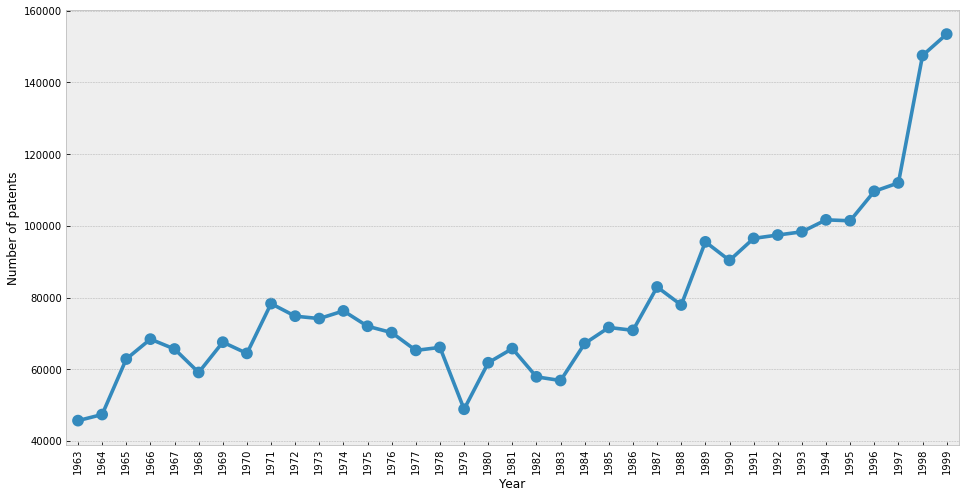

In [15]:
f, ax1 = plt.subplots(1, figsize=(16,8))
plt.xticks(rotation=90)
g=sbn.pointplot(x=year_trend.index, y='PATENT',  data=year_trend, ax=ax1)
g.set(xlabel='Year', ylabel='Number of patents')

We can see that the number of granted patents is constantly increasing through the years, except for the period from 1974-1983 when there was some decrease, probably caused by some events in the world.

* **Which countries have the most assigned patents?**

Will try to answer this question for patents from year 1998.

In [16]:
country_trend = df[['PATENT', 'COUNTRY', 'GYEAR']]
country_trend = country_trend[country_trend['GYEAR']==1998].drop('GYEAR', axis=1)
country_trend = country_trend.groupby('COUNTRY').count()
country_trend.head()

,PATENT
COUNTRY,
AD,2
AE,1
AI,1
AN,1
AR,43


In [17]:
country_trend2 = country_trend.merge(countries, left_index=True, right_on='Code').set_index('Code')
country_trend2.sort_values(by=['PATENT'], ascending=False).head(15)

,PATENT,Country
Code,,
US,80291,UNITED STATES
JP,30840,JAPAN
DE,9095,GERMANY
FR,3674,FRANCE
GB,3464,UNITED KINGDOM
KR,3259,SOUTH KOREA
TW,3100,TAIWAN
CA,2974,CANADA
IT,1584,ITALY


In [18]:
def popup_text(country_code):
    rate=int(country_trend2[country_trend2.index==country_code].PATENT)
    country=country_trend2[country_trend2.index==country_code].iloc[0]['Country']
        
    html = "<h5>" + country + " number of patents in 1998: " + "<br>"
    html += str(rate) + "</h5><br>"
    
    return html

In [19]:
world = [52, 18] 
m = folium.Map(location=world, tiles='cartodbpositron', zoom_start=2)

countries_geo_path = 'data/countries.geo.json'
geo_json_data = json.load(open(countries_geo_path))

def get_color(value):
    if value >=1 and value < 500:
        return '#fff0e6'
    elif value >= 500 and value < 1000:
        return '#ffc299'
    elif value >= 1000 and value < 5000:
        return '#ff751a'
    elif value >= 5000 and value < 10000:
        return '#993d00'
    elif value >= 10000:
        return '#1a0a00'
    
countries_map = []
patent_dict = country_trend2['PATENT']

for i in geo_json_data['features']:
    popup_html = popup_text(i['id'])
    popup = folium.Popup(html=popup_html, max_width=500)
    
    country_json=folium.GeoJson(
    i,
    style_function=lambda i: {
        'fillColor': get_color(patent_dict[i['id']]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9
    }
    )
    country_json.add_child(popup)
    country_json.add_to(m)

In [20]:
m

*You can click on every country to see the exact number of patents.*

As expected, United States are in the first place with 80291 registered patents, and they even have more patents than all other countries together. In second place is Japan with 30840 patents and then is Germany with 9095 patents. From the results we can see that the patents are unevenly distributed, there are only three countries with more than 9000 patents, and only one country with more than 50000 registered patents. All other countries have less than 4000 registered patents during the year 1998.

* **What are the most popular technology fields for patents through the years?**

In this section, we are interested in changes in number of patents in each technology field through the years. To answer this question, We only need pat63_99 dataset.

Our dataset contains in total 2923922 entries from 1963 to 1999. Thus let's group our dataset by years to find "time" dataframe which contains number of patents in each category thorough the these years.

In [21]:
#Finding all the unique year values to save time
years=np.sort(df["GYEAR"].unique())
time=[]
for year in years:
    #for each dataframe section in given year
    current=df[df["GYEAR"]==year]
    #group dataframe by CAT field (CAT for technology category)
    numbers=current.groupby('CAT')['PATENT'].nunique()
    time.append(numbers)
#transform our dataset into dataframe for convenience
time=pd.DataFrame(time)
time["Time"]=years
time=time.set_index("Time")

Now let's see the results

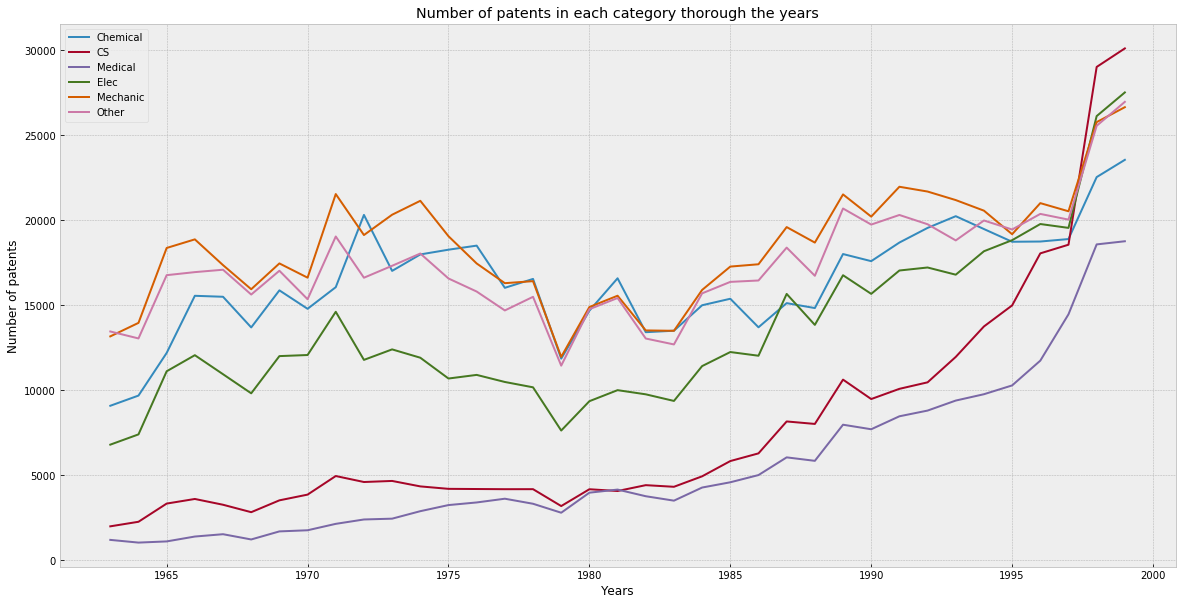

In [22]:
idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,time[idx],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of patents in each category through the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

So according to the graph above the most popular technology field from 1965 to 2000 was Mechanics. In general every technology field's line follow similar pattern except Computer Science and Medical Science, which increased dramatically over the 40 years. Interestengly, there is noticeable gap in 1979 in all fields. In general, we can say electronics and mechanics are popular fields but Computer science is the most trending field and have tendency to become the most popular field since 2000.

* **What's the most frequent technology field by inventor's country?**

In this section, we are interested in most frequent technology field by inventor's country. We can follow similar procedure as previous section, since we are interested in number of patents also. Let's create country dataframe which contains number of patents of each country. 

In [23]:
#Finding all the country IDs
countries=np.sort(df["COUNTRY"].unique())
country=[]
for c in countries:
    current=df[df["COUNTRY"]==c]
    numbers=current.groupby('CAT')['PATENT'].nunique()
    country.append(numbers)
#Adding ornaments to the graph
country=pd.DataFrame(country)
country["Country"]=countries
country=country.set_index("Country")
country.head()

CAT,1,2,3,4,5,6
Country,,,,,,
AD,NaN,NaN,NaN,NaN,3.0,3.0
AE,2.0,1.0,NaN,1.0,NaN,14.0
AG,1.0,1.0,NaN,2.0,4.0,1.0
AI,NaN,NaN,NaN,NaN,NaN,1.0
AL,NaN,NaN,NaN,NaN,1.0,NaN


So since we have so many countries, It would be not very informative to analyze each countries. Thus let's describe our data and focus on 5 countries with highest number of patents in total 

In [24]:
#Describing the country
country.describe()

CAT,1,2,3,4,5,6
count,120.000000,90.000000,103.000000,116.000000,129.000000,131.000000
mean,5057.783333,3225.966667,1982.514563,4308.112069,5282.000000,4895.671756
std,33839.945880,19220.116358,13078.685864,28597.223763,36342.836344,38861.265088
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000
50%,11.500000,9.500000,14.000000,8.000000,12.000000,15.000000
75%,191.000000,120.500000,151.500000,139.250000,178.000000,127.500000
max,357198.000000,167941.000000,130840.000000,293168.000000,395215.000000,440627.000000


The data description indicates only few countries possess the highest number of inventors, which is solid assumption due to educational and research opportunities in developed countries.

In [25]:
#Ordering dataframe by total number of patents
ordered=country.fillna(0)
ordered["total"]=np.sum(ordered,axis=1)
ordered=ordered.sort_values("total",ascending=False)
ordered.head()

CAT,1,2,3,4,5,6,total
Country,,,,,,,
US,357198.0,167941.0,130840.0,293168.0,395215.0,440627.0,1784989.0
JP,81763.0,72934.0,19145.0,91655.0,105013.0,50931.0,421441.0
DE,61689.0,10306.0,13608.0,32986.0,62916.0,39590.0,221095.0
GB,21666.0,8083.0,8553.0,17149.0,23960.0,18601.0,98012.0
FR,18488.0,8017.0,7697.0,15889.0,20203.0,15104.0,85398.0


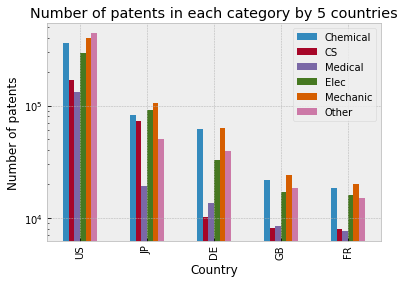

In [26]:
#Plotting first 5 ocuntries
interested=ordered.head()
interested=interested.drop(['total'], axis=1)
interested.columns = names
interested.plot(kind='bar',logy=True)
plt.title("Number of patents in each category by 5 countries")
plt.ylabel("Number of patents")
plt.show()

The graph above shows interesting relation, which is computer science inventors from US and Japan are much more higher than that of other countries. And also, these 2 countries have more inventors than any other countries. Other than that this bar plot shows similar trend with previos section's results.

* **What percentage of patents belongs to privates and what to organizations?**

Here we found out that the dataset is even more accurate as there are several assignee types in the column "ASSCODE":

    1 = unassigned
    2 = assigned to a U.S. nongovernment organization
    3 = assigned to a non-U.S., nongovernment organization
    4 = assigned to a U.S. individual
    5 = assigned to a non-U.S. individual
    6 = assigned to the U.S. (Federal) Government
    7 = assigned to a non-U.S. government

In [27]:
assignee = df[['PATENT', 'ASSCODE']]
assignee = assignee.groupby('ASSCODE').count()
assignee

,PATENT
ASSCODE,
1,537988
2,1380310
3,913470
4,24097
5,9146
6,48323
7,10588


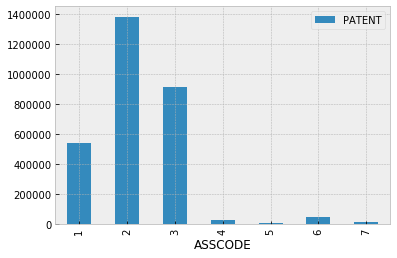

In [28]:
assignee.plot.bar()

In [33]:
assignee_perc=[]
assignee_perc.append( (assignee.loc[2]+assignee.loc[3])/assignee.sum()*100 )
assignee_perc[0]

PATENT    78.448741
dtype: float64

78.4% of the patents belong to nongovernment organizations

In [34]:
assignee_perc.append( (assignee.loc[4]+assignee.loc[5])/assignee.sum()*100 )
assignee_perc[1]

PATENT    1.136932
dtype: float64

1.1% of the patents belong to privates

In [35]:
assignee_perc.append( (assignee.loc[6]+assignee.loc[7])/assignee.sum()*100 )
assignee_perc[2]

PATENT    2.014794
dtype: float64

2.0% of the patents belong to governments all over the world

In [38]:
assignee_perc.append(100-assignee_perc[2]-assignee_perc[1]-assignee_perc[0])
assignee_perc[3]

PATENT    18.399533
dtype: float64

18.4% of the patents are unassigned

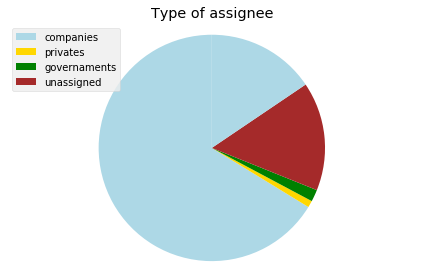

In [39]:
labels = ['companies','privates','governaments','unassigned']
colors = ['lightblue', 'gold', 'green', 'brown']
patches, texts = plt.pie(assignee_perc, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.title("Type of assignee")
plt.axis('equal')
plt.tight_layout()
plt.show()

## Patent citations

One part of this dataset is a network(graph) dataset, so will focus now a little bit on it. We will try to analyse patent citations and answer some questions. 

First let's try to visualize the dataset. Because the graph dataset is too large with more then 3 million nodes and more then 16 million edges, we will show just one small part of it. 

In [52]:
citations = pd.read_csv('data/cit-Patents.txt', sep='\t', skiprows=[0,1,2])
citations.head()

,# FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In [54]:
df_graph = pd.read_csv('data/apat63_99.csv')[['PATENT', 'GYEAR', 'COUNTRY']]
df_graph.head()

,PATENT,GYEAR,COUNTRY
0,3070801,1963,BE
1,3070802,1963,US
2,3070803,1963,US
3,3070804,1963,US
4,3070805,1963,US


In [55]:
citations_year_ch = citations.merge(df_graph, left_on='# FromNodeId', right_on='PATENT').merge(df_graph, left_on='ToNodeId', right_on='PATENT')
citations_year_ch = citations_year_ch[(citations_year_ch['COUNTRY_x']=='US') & (citations_year_ch['COUNTRY_y']=='CH')]
citations_year_ch = citations_year_ch[(citations_year_ch['GYEAR_y']==1998)]
citations_year_ch.head()

,# FromNodeId,ToNodeId,PATENT_x,GYEAR_x,COUNTRY_x,PATENT_y,GYEAR_y,COUNTRY_y
11403126,5922473,5767169,5922473,1999,US,5767169,1998,CH
11403127,5925402,5767169,5925402,1999,US,5767169,1998,CH
11403128,6005017,5767169,6005017,1999,US,5767169,1998,CH
13657168,5937786,5713301,5937786,1999,US,5713301,1998,CH
13725636,5828493,5760981,5828493,1998,US,5760981,1998,CH


In [56]:
G = nx.Graph()

for i, row in citations_year_ch.iterrows():
        G.add_edge(row['# FromNodeId'], row['ToNodeId'])

In [57]:
pos = nx.random_layout(G)

In [45]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    edge_trace['x'] += [pos[edge[0]][0],pos[edge[1]][0], None]
    edge_trace['y'] += [pos[edge[0]][1],pos[edge[1]][1], None] 

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Number of citations',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for nd in G.nodes():
    node_trace['x'].append(pos[nd][0])
    node_trace['y'].append(pos[nd][1])

In [13]:
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    node_info = '# of citations: '+str(len(adjacencies))
    node_trace['text'].append(node_info)

In [14]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Swiss patents from 1998 cited by US patents',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
config={'showLink': False}

The next graph is showing Swiss patents from year 1998 which are cited by patents granted in United States.

In [15]:
py.iplot(fig, filename='networkx', config=config)

Now, we will start simplifying the dataset deleting not important columns and we will end up having a look at the citations flows among categories of patents, over time.

In [59]:
#keeping only rows related to citations

df_citations = df[['PATENT', 'GYEAR','CAT','CMADE','CRECEIVE','RATIOCIT','FWDAPLAG','BCKGTLAG','SELFCTUB','SELFCTLB','SECDUPBD','SECDLWBD']]
df_citations.head()

,PATENT,GYEAR,CAT,CMADE,CRECEIVE,RATIOCIT,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,6,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,6,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,6,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,6,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,6,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#printing how many missing values each variable has

num_valid_entries_per_column = df_citations.count(axis=0)
print (num_valid_entries_per_column)

PATENT      2923922
GYEAR       2923922
CAT         2923922
CMADE       2139314
CRECEIVE    2923922
RATIOCIT    2088795
FWDAPLAG    2074641
BCKGTLAG    2088785
SELFCTUB    1703004
SELFCTLB    1703004
SECDUPBD    1599160
SECDLWBD    1599160
dtype: int64


* **Are the citations made and the citations received increasing with passing of the years?**

In [61]:
citations_byyear_abs = df[['PATENT','GYEAR','CMADE','CRECEIVE']]
citations_byyear_abs = citations_byyear_abs.groupby('GYEAR').agg({'PATENT':'count', 'CMADE': 'sum','CRECEIVE':'sum'})
citations_byyear_abs.head()

,PATENT,CMADE,CRECEIVE
GYEAR,,,
1963,45679,NaN,132384
1964,47375,NaN,142509
1965,62857,NaN,201121
1966,68405,NaN,232494
1967,65652,NaN,236860


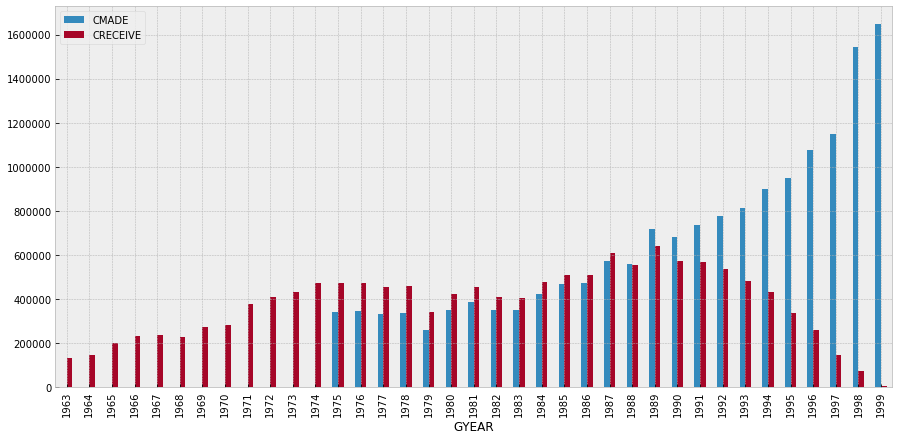

In [62]:
citations_byyear_abs.drop('PATENT',axis=1).plot.bar(figsize=(15,7))

We can see that the citations made are missing for years before 1975. The citations received decrease linearly the last 10 years, this makes sense because a new patent is less likely to have many citations.

So far we showed the absolute numbers, but would make more sense to analyse for each year the citations relative to the total number of patents granted in that year.

In [63]:
citations_byyear_abs[['CRECEIVE']] = citations_byyear_abs['CRECEIVE']/citations_byyear_abs['PATENT']
citations_byyear_abs[['CMADE']] = citations_byyear_abs['CMADE']/citations_byyear_abs['PATENT']
citations_byyear= citations_byyear_abs.round(2)
citations_byyear.head()

,PATENT,CMADE,CRECEIVE
GYEAR,,,
1963,45679,NaN,2.90
1964,47375,NaN,3.01
1965,62857,NaN,3.20
1966,68405,NaN,3.40
1967,65652,NaN,3.61


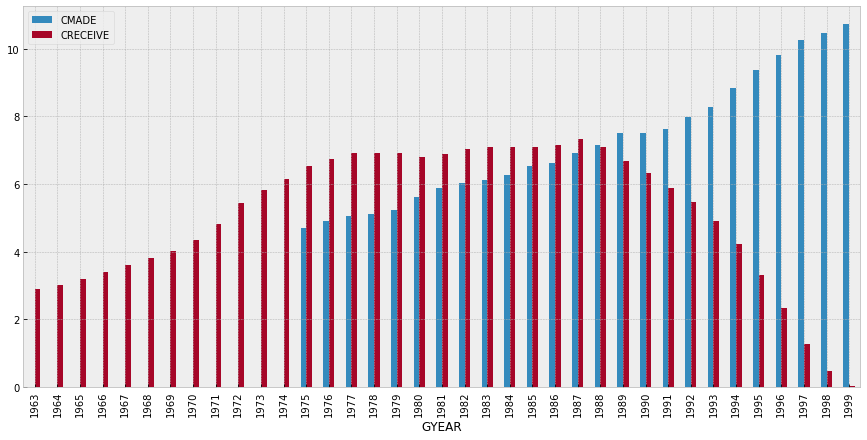

In [64]:
citations_byyear_abs.drop('PATENT',axis=1).plot.bar(figsize=(15,7))

We can still notice an increase in the citations both made and received over time, probably because of the globalization and the world wide web, which made easier to access information from all over the world.

* **How does the number of citations relate to the category of the patent?**

We use the variable "CAT", which inform about the macro category of the patent. There are 6 classes:

    Chemical
    CS
    Medical
    Elec
    Mechanic
    Other
The category "other" includes Textile, Heating, Food and other miscellaneous.

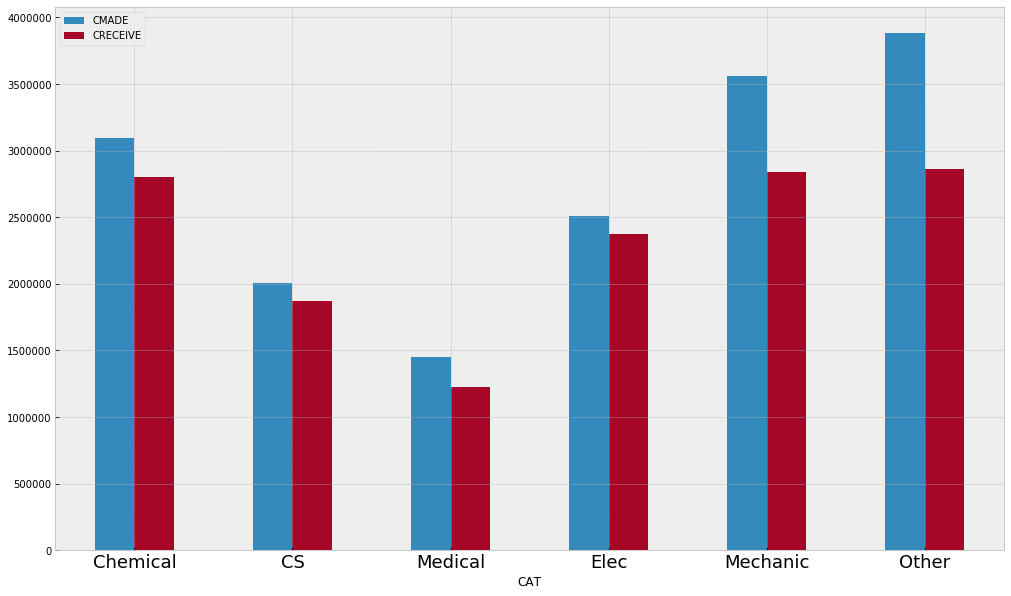

In [65]:
citations_bycategory_abs= df[['PATENT','GYEAR','CAT','CMADE','CRECEIVE']].groupby('CAT').agg({'PATENT':'count', 'CMADE': 'sum','CRECEIVE':'sum'})

#Category fields
labels=["Chemical","CS","Medical","Elec","Mechanic","Other"]

citations_bycategory_abs.drop(['PATENT'],axis=1).plot.bar(figsize=(17,10)).set_xticklabels(labels, rotation='horizontal', fontsize=18)

As before, for a more meaningful visualization is better to divide for the total number of patents that a category has.

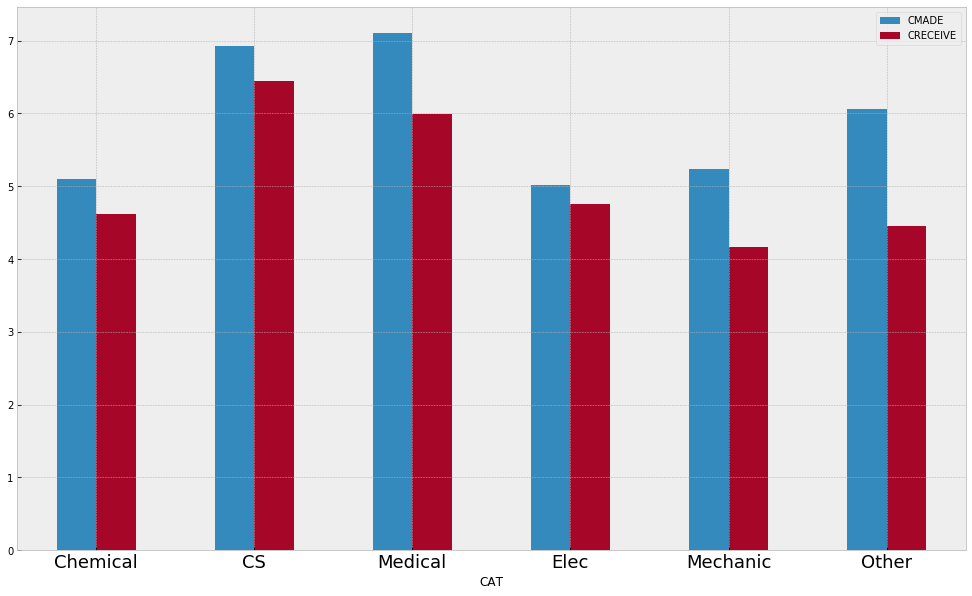

In [66]:
citations_bycategory_abs[['CRECEIVE']] = citations_bycategory_abs['CRECEIVE']/citations_bycategory_abs['PATENT']
citations_bycategory_abs[['CMADE']] = citations_bycategory_abs['CMADE']/citations_bycategory_abs['PATENT']
citations_bycategory= citations_bycategory_abs.round(2)
citations_bycategory.drop(['PATENT'],axis=1).plot.bar(figsize=(17,10)).set_xticklabels(labels, rotation='horizontal', fontsize=18)

The bar plot shows that patents in Computer Science and Medicine are more cited and make more citations as well. The citations received are always less for the contribute of the novel patents that we showed before.

* **Displaying citations flows among categories of patents over time**

In [69]:
df_citations_flows=df_citations[['PATENT','GYEAR','CAT','CMADE','CRECEIVE']]
df_citations_flows_grouped= df_citations_flows.groupby(['GYEAR', 'CAT']).agg({'PATENT':'count','CMADE':'sum','CRECEIVE':'sum'})
df_citations_flows_grouped.head(10)

PATENT  CMADE  CRECEIVE
GYEAR CAT                         
1963  1      9082    NaN     25953
      2      1993    NaN      3943
      3      1196    NaN      5847
      4      6796    NaN     15023
      5     13162    NaN     36481
      6     13450    NaN     45137
1964  1      9681    NaN     29784
      2      2261    NaN      4490
      3      1037    NaN      5552
      4      7399    NaN     17010

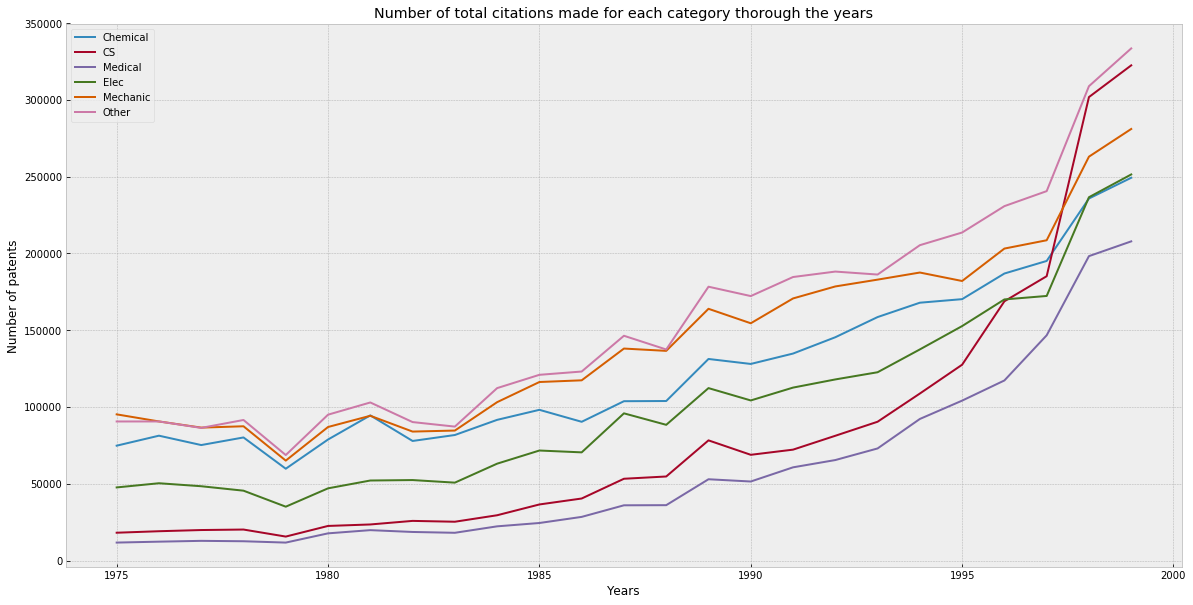

In [70]:
# plotting the Number of total citations made for each category thorough the years

idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,df_citations_flows_grouped.loc(axis=0)[:,idx]['CMADE'],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of total citations made for each category through the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

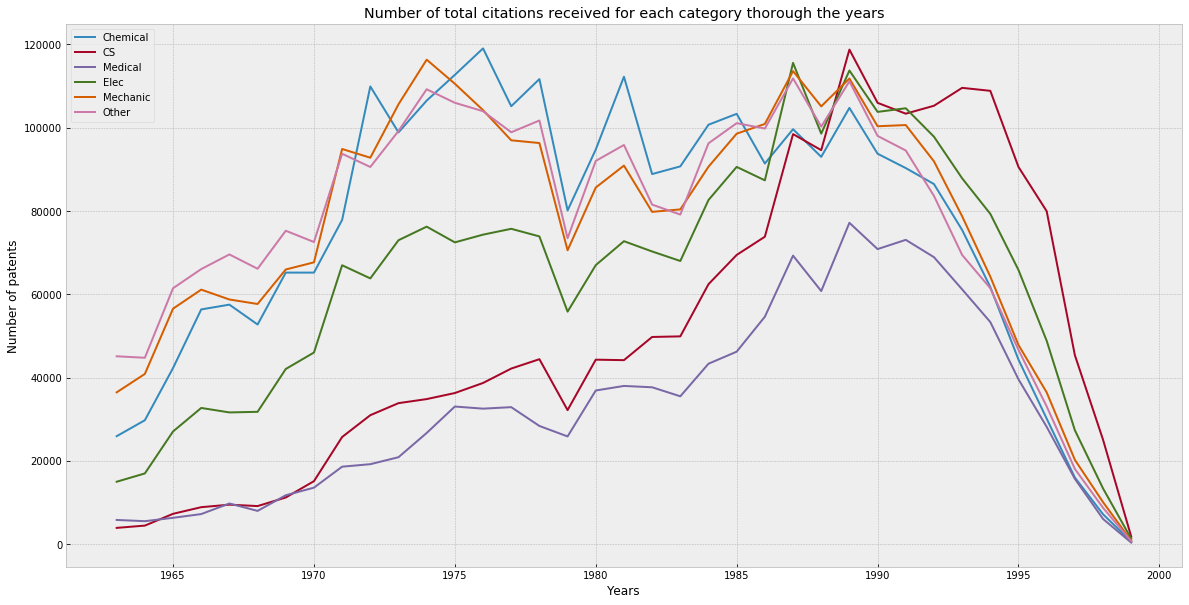

In [71]:
# plotting the Number of total citations received for each category thorough the years since

idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,df_citations_flows_grouped.loc(axis=0)[:,idx]['CRECEIVE'],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of total citations received for each category through the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

We will now plot the flows of the average number of citations made and received by category, over time.

In [72]:
df_citations_flows_grouped[['CRECEIVE']] = df_citations_flows_grouped['CRECEIVE']/df_citations_flows_grouped['PATENT']
df_citations_flows_grouped[['CMADE']] = df_citations_flows_grouped['CMADE']/df_citations_flows_grouped['PATENT']
df_citations_flows_grouped_avg= df_citations_flows_grouped.round(2)
df_citations_flows_grouped_avg.head(8)

PATENT  CMADE  CRECEIVE
GYEAR CAT                         
1963  1      9082    NaN      2.86
      2      1993    NaN      1.98
      3      1196    NaN      4.89
      4      6796    NaN      2.21
      5     13162    NaN      2.77
      6     13450    NaN      3.36
1964  1      9681    NaN      3.08
      2      2261    NaN      1.99

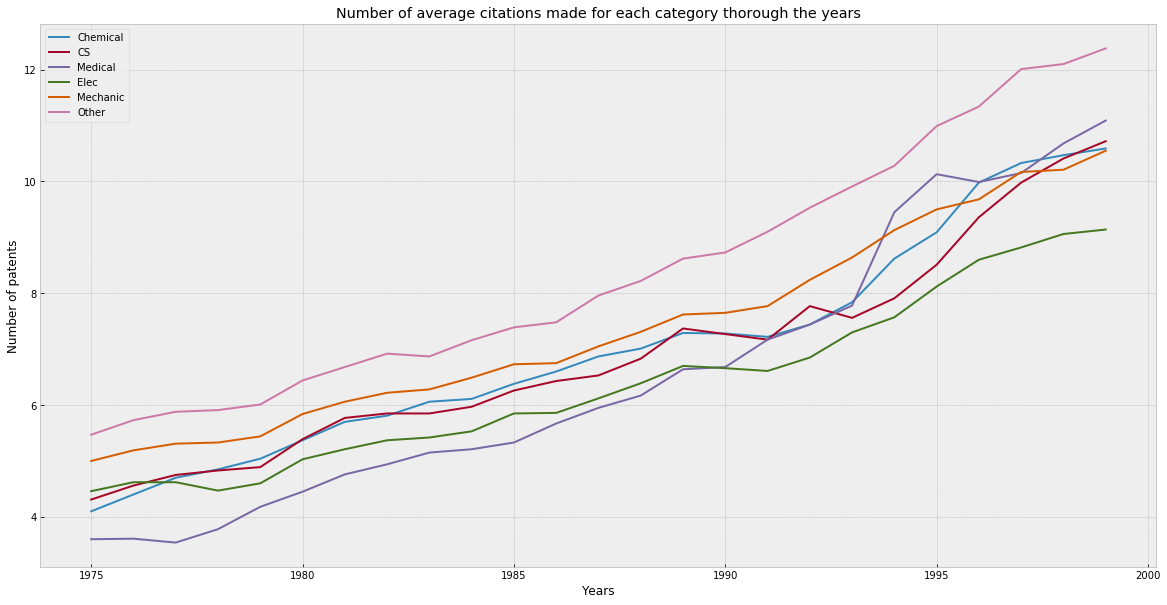

In [75]:
# plotting the average number of total citations made
# for each category through the years

idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,df_citations_flows_grouped_avg.loc(axis=0)[:,idx]['CMADE'],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of average citations made for each category through the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

The number of citations made is steadly growing through the years, probably because of the globalization and the world wide web, which made easier to access information from all over the world.
The category "other" (including Textile, Heating, Food and other miscellaneous) has on average more citations than the other categories. 

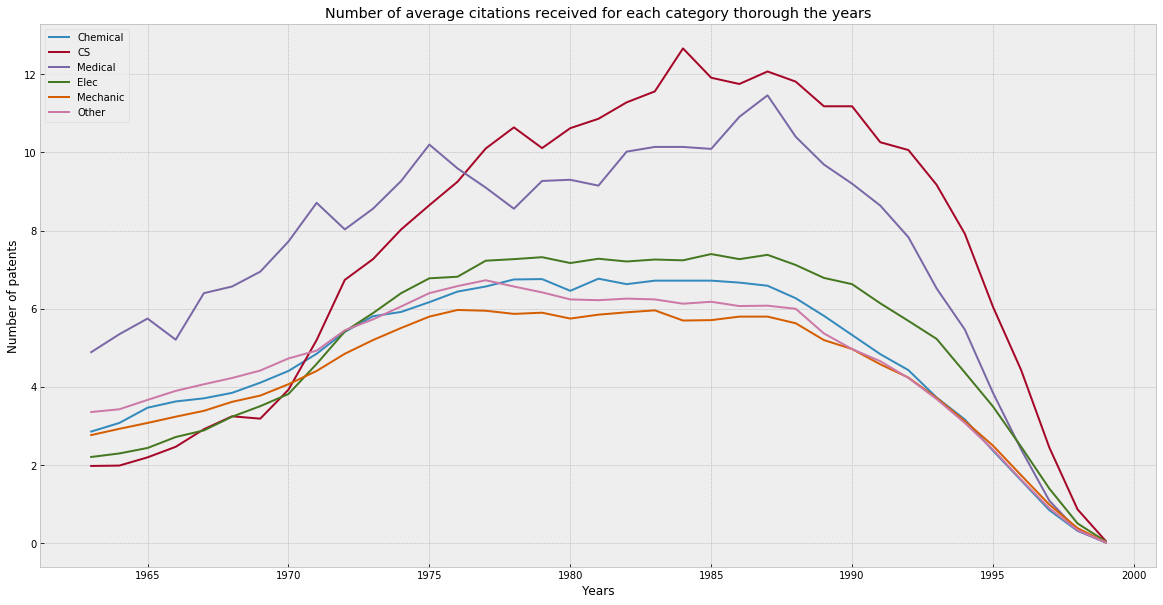

In [76]:
# plotting the average number of total citations received
# for each category through the years

idxs=range(1,7)
#Category fields
names=["Chemical","CS","Medical","Elec","Mechanic","Other"]
plt.figure(figsize=(20,10))
for idx in idxs:
    plt.plot(years,df_citations_flows_grouped_avg.loc(axis=0)[:,idx]['CRECEIVE'],label=names[idx-1])
#Ornaments for graph
plt.legend(loc='upper left')
plt.title("Number of average citations received for each category through the years")
plt.ylabel("Number of patents")
plt.xlabel("Years")
plt.show()

The average citations received increase with passing of the time for every category till the 80', but after that they occurr into a decrease, caused by the new patents which are less likely to have many citations. Indeed, documents that cite a patent are usually at least 12 months newer than the cited patent due to a lag in publishing of filed applications.
The categories of Chemical and Computer Science receive more citations on average, with the second which started having less citations than the others before 1965, and became the leading cathegory after 15 years, when this sector exploded.

### Citation lag
The forward lags focus on the time difference between the application or grant year of the cited patent, and that of the citing patents. And thus, we can measure probability of recieving citation since the grant.

In [21]:
#Calculating the histogram
forward_lag=patents['FWDAPLAG'][patents['FWDAPLAG'].notnull()]
count, division = np.histogram(forward_lag, bins = 100)

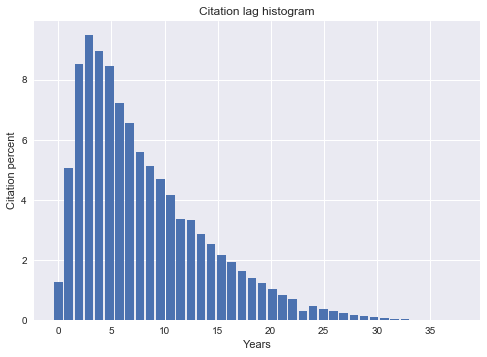

In [28]:
#Normalizing and displaying the histogram
plt.bar(division[0:40],count[0:40]*100/sum(count))
plt.ylabel("Citation percent")
plt.xlabel("Years")
plt.title("Citation lag histogram")
plt.show()

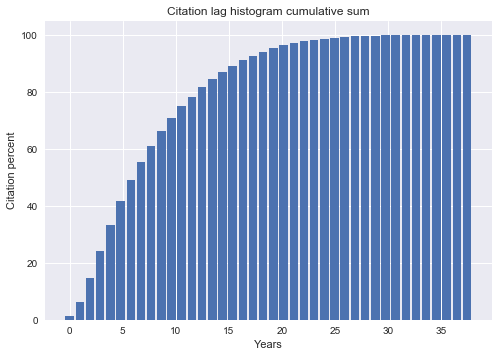

In [29]:
plt.bar(division[0:40],np.cumsum(count[0:40]*100/sum(count)))
plt.ylabel("Citation percent")
plt.xlabel("Years")
plt.title("Citation lag histogram cumulative sum")
plt.show()

According to our graph, almost 40 % of the total citations were made within 5 years since the grant, and 80 % after 13 years.

## The impact criteria

   The number of patents and their quality is important index of country's innovation and economic growth. However, according to our dataset, the total number of patents granted by only US Patent and Trademark Office (USPTO) from 1963 to 1999 is almost 3 million. In other words, over 200 patents were granted per day, and it's increasing over time. Such exponential growth raises important questions like "How can one measure patent's quality", "How to distinguish high quality patents" and "Is it possible to predict, if patent is good or bad". By answering to those questions, both researchers and business companies can benefit and save huge amount of assets and time.

   In this section, we will try to measure both economical and academic impacts of each patents and try to find if there is any correlation or interesting relationship between them. In order to do that, we have used NBER patents dataset and fortune rankings list from 1963 to 1999

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import Imputer
#Reading our dataset
patents = pd.read_csv('data/pat63_99.txt',low_memory=False)
patents.head()

,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,...,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
patents.shape

(2923922, 23)

As mentioned above our dataset is huge and contains information about almost 3 million patents

### Defining Academic Impact

According to the https://www.nap.edu/read/5976/chapter/7, the number of patents issued and the technical and scientific literature citations on the patents can be used to develop quantitative measures of innovative output and science-technology linkages. Thus, to measure academic impact of each patent, we have used number of citations it has recieved using citations dataset. Even though our citation dataset contains only informations related from 1975 to 1999, there is over 16 millioin citation relationships between patents.

In [14]:
#reading the dataset
citations = pd.read_csv('data/cite75_99.txt',low_memory=False)
print ("lenght: ",len(citations))
citations.head()

lenght:  16522438


,CITING,CITED
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In order to calculate total number of citations each patent has recieved, we have grouped our dataset by column CITED and counted patents. And then saved it into dataframe "academic", which represents academic impact.

In [15]:
cited_patents=citations.CITED.unique()
len(cited_patents)
cited_patents.sort()
d={'id':cited_patents}
academic=pd.DataFrame(d)
academic=academic.set_index('id')

In [16]:
#Citation count
grouped=citations.groupby(['CITED']).count()
cnt1=grouped.CITING
cnt1.shape

(3258983,)

In [17]:
academic["first"]=cnt1
academic.head()

,first
id,
1,2
13,2
24,1
29,1
31,2


The number of citations each patent recieved isn't good method to evaluate academic impact. Because, the patent which influenced another patent which has recieved huge amount of citations, might have bigger impact, but number of citations alone can't represent such cases. So, we have measured second layer of citations, which is the number of citations of each citing patents recieved for given patent.
In order to calculate we have used previous method on column "first" of dataset "academic"

In [18]:
#Citation count 2nd layer
citations2=citations.set_index('CITING')
#This time counting on number of citaions
citations2['first']=cnt1
citations2=citations2.fillna(0)
#And summing instead of counting
grouped=citations2.groupby(['CITED']).sum()
np.sum(grouped)

first    82196226.0
dtype: float64

In [19]:
academic["second"]=grouped["first"]
academic.head()

,first,second
id,,
1,2,3.0
13,2,2.0
24,1,1.0
29,1,5.0
31,2,3.0


The table above is the final result of our method. Since we don't know the ground truth of academic impact of each patents, we couldn't combine our columns "first" and "second". Hence we leave it as it is, and use it for further analyzation.

### What features influence on academic qualities of patents?
In order to answer this question, we have used Pearson Correlation Coefficient with 2 columns of "academic" dataset and 23 features in patents dataset. This coefficient will tell us is there linear relationship between 2 series, and if yes is it negative or positive. https://en.wikipedia.org/wiki/Pearson_correlation_coefficient . 

In [61]:
#Preparing our first and second values from academic dataset according to the indices of patents dataset
conds=patents["PATENT"].isin(academic.index.values)
first=pd.Series([academic['first'][indice] if cond else 0 for indice,cond in zip(patents['PATENT'],conds)])
second=pd.Series([academic['second'][indice] if cond else 0 for indice,cond in zip(patents['PATENT'],conds)])

#Just to save results
cors_first=[]
cors_second=[]
print("Started correlation calculation")

#Since correlation coefficient can be calculated on only numeric values, we have to convert String features
X = patents.fillna({'COUNTRY': 'None','POSTATE': 'None'})
for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
#Actually calculating them        
for cat in X.columns:
    a=X[cat].corr(first)
    b=X[cat].corr(second)
    cors_first.append(a)
    cors_second.append(b)
    print(a,b)
academic_correlations=pd.DataFrame({"features":patents.columns,"corr_first":cors_first,"corr_second":cors_second})

Started correlation calculation
-0.127064279754 -0.142381214876
-0.0989003966106 -0.127678064031
-0.0992950689251 -0.127856745055
-0.150318942084 -0.165095482049
0.0651468436751 0.0520329884969
-0.0420312318377 -0.0340598564677
-0.0625061387289 -0.040745707808
-0.0250669308173 -0.0164916873362
0.0866117906288 0.0415661233073
0.0673333248903 0.0817866554477
-0.0440009649877 -0.0555616304924
-0.0434918551997 -0.0571025349153
0.00415040607772 -0.0159433593511
1.0 0.811515221298
0.0417665137474 0.0389071134314
0.354651720017 0.231379895982
0.039013434809 0.0294263437358
0.0776716235831 0.1038078317
-0.11596545404 -0.0984959912491
0.000495921511426 -0.000511082802355
-0.00374787373575 -0.00358180549142
-0.0142371444536 -0.029868788599
-0.0165808661317 -0.0304252385188


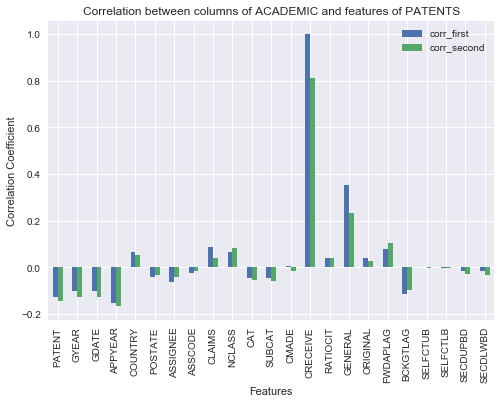

In [136]:
#Let's see our results
academic_correlations.plot.bar()
plt.xticks( range(23), patents.columns )
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.title("Correlation between columns of ACADEMIC and features of PATENTS")
plt.show()

According to the graph the academic impact of each patents are decreasing as time passes, which can be explained by increasing number of patents in each year. As expected, the CRECIEVE feature, which is number of citations recieved has highest correllation. But also note that it's value is 0.811 with second column of ACADEMIC dataset. And also, the generality which is measurement of how much scientific area does patent cover, has quite high correlation. In other words, the patents which covers wide area, have that much influence academically.

### Defining Economic Impact

The dataset provided by NBER doesn't have any information related to economy except the company names of each patents are assigned to. Thus, in this section, we have scraped Fortune magazine's rankings of top 500 companies in US over 1963 to 1999, with their revenues and profits in million (http://archive.fortune.com/magazines/fortune/fortune500_archive/full/). By combining these 2 datasets, we can get patents information of each company owns and their economic measurements for given year.

In [2]:
import requests
from bs4 import BeautifulSoup
import seaborn as sbn
#getting forbes data from 1963 to 1999
fortune=pd.DataFrame({'id':range(1,500*37+1),'year':0,'rank':0,'company':'','revenue':0,'profit':0})
fortune=fortune.set_index('id')
#This line is for just to match url with 
baseurl='http://archive.fortune.com/magazines/fortune/fortune500_archive/full/'
subs=['/1.html','/101.html','/201.html','/301.html','/401.html']
print('Started')
# Function for processing row. Which includes converting string values of profit and revenue to int and filling not available datas
def row_processor(row):
    cols=row.find_all('td')
    rank=int(cols[0].string)
    company=cols[1].a.string
    try:
        revenue=float(cols[2].string.replace(',', ''))
        profit=float(cols[3].string.replace(',', ''))
        return [rank,company,revenue,profit]
    except:
        return [rank,company,0,0]
y=0
#Looping over years
for year in range(1963,2000):
    #Looping over sub lists
    for lasturl in subs:
        #requesting
        r = requests.get(baseurl+str(year)+lasturl)
        soup = BeautifulSoup(r.text, 'html.parser')
        #Finding our table
        table = soup.find('table', class_='maglisttable')
        rows=table.find_all('tr',{"id": "tablerow"})
        #Saving them
        fortune['year'][range(y,y+100)]=year
        datas=[row_processor(row) for row in rows]
        fortune['rank'][range(y,y+100)]=[data[0] for data in datas]
        fortune['company'][range(y,y+100)]=[data[1] for data in datas]
        fortune['revenue'][range(y,y+100)]=[data[2] for data in datas]
        fortune['profit'][range(y,y+100)]=[data[3] for data in datas]
        y+=100
        #Just to see how things are going
        print(str(year)+lasturl)

Started


C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bilguun\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A

1963/1.html
1963/101.html
1963/201.html
1963/301.html
1963/401.html
1964/1.html
1964/101.html
1964/201.html
1964/301.html
1964/401.html
1965/1.html
1965/101.html
1965/201.html
1965/301.html
1965/401.html
1966/1.html
1966/101.html
1966/201.html
1966/301.html
1966/401.html
1967/1.html
1967/101.html
1967/201.html
1967/301.html
1967/401.html
1968/1.html
1968/101.html
1968/201.html
1968/301.html
1968/401.html
1969/1.html
1969/101.html
1969/201.html
1969/301.html
1969/401.html
1970/1.html
1970/101.html
1970/201.html
1970/301.html
1970/401.html
1971/1.html
1971/101.html
1971/201.html
1971/301.html
1971/401.html
1972/1.html
1972/101.html
1972/201.html
1972/301.html
1972/401.html
1973/1.html
1973/101.html
1973/201.html
1973/301.html
1973/401.html
1974/1.html
1974/101.html
1974/201.html
1974/301.html
1974/401.html
1975/1.html
1975/101.html
1975/201.html
1975/301.html
1975/401.html
1976/1.html
1976/101.html
1976/201.html
1976/301.html
1976/401.html
1977/1.html
1977/101.html
1977/201.html
1977/301

In [3]:
fortune.head()

,company,profit,rank,revenue,year
id,,,,,
1,General Motors,1459.1,1,14640.2,1963
2,Exxon Mobil,840.9,2,9536.9,1963
3,Ford Motor,480.7,3,8089.6,1963
4,General Electric,265.8,4,4792.7,1963
5,Mobil,242.3,5,3933.3,1963


Voila, we have successfully scraped out data. And now, we have to match the names of the companies between FORTUNE and PATENTS dataset. The Assignee id and company name conversion table is in coname file.

In [4]:
#matching coname with list companies
fort_names=fortune.company.unique()
fort_names.sort()
#Reading the company names
coname = pd.read_csv('data/coname.txt',low_memory=False)
conames=coname.COMPNAME.unique()
#Let's see company names of FORTUNE and PATENTS datasets.
print(fort_names)
print(conames)

['3Com' '3M' 'A-T-O' ..., 'Yum Brands' 'Zenith Electronics'
 'Zurn Industries']
['AAA ASSOCIATES, INC.' 'AAA OFFICE COFFEE SERVICE, INC.'
 'AAA PIPE CLEANING CORPORATION' ..., 'LUCAS NOVASENSOR INC.'
 'LOTS TECHNOLOGY, INC.' 'NEUTRAL POSTURE ERGONOMICS, INC.']


The company names of PATENTS dataset has only uppercase letters and have full names of companies and their sub-companies. However, in Fortune dataset, the companies names were summed up by their group names. Thus we have defined closest function, which returns the closest match between given name in the given list, and created company names conversion table between 2 datasets.

In [5]:
def closest(aname,bnames):
    for bname in bnames:
        if aname.startswith(bname.upper()):
            return bname
    return ''
coname['fortune']=[closest(aname,fort_names) for aname in coname.COMPNAME]

In [6]:
coname.head()

,ASSIGNEE,COMPNAME,fortune
0,5,"AAA ASSOCIATES, INC.",
1,10,"AAA OFFICE COFFEE SERVICE, INC.",
2,15,AAA PIPE CLEANING CORPORATION,
3,20,AAA PRODUCTS INTERNATIONAL INC.,
4,25,"AAA SALES & ENGINEERING, INC.",


Voila, Our table is finished. Now let's look at some characteristics

In [7]:
sum(coname['fortune']=='')

169829

In [8]:
len(fort_names)

1564

According to our table, we couldn't found the match of almost 170k companies mentioned in PATENTS. However, note that in fortune dataset, there is only information about 1564 top companies

In [9]:
#Removing companies that we couldn't found the match
companies=coname[coname['fortune']!='']
companies

,ASSIGNEE,COMPNAME,fortune
132,735,ABBOTT LABORATORIES,Abbott Laboratories
266,1450,ABEX CORPORATION,Abex
267,1455,ABEX INDUSTRIES OF CANADA LTD.,Abex
268,1460,ABEX PAGID REIBBELAG GMBH,Abex
642,3470,ACCO INDUSTRIES INC.,Acco Industries
794,4235,"ACF INDUSTRIES, INCORPORATED",ACF Industries
1274,6800,"ADMIRAL COATED PRODUCTS, INC.",Admiral
1275,6805,ADMIRAL CORPORATION,Admiral
1276,6810,ADMIRAL DESIGN AND RESEARCH LIMITED,Admiral
1277,6815,ADMIRAL EQUIPMENT COMPANY,Admiral


Looks like our conversion was pretty successful. So let's see how much patents these top companies own

In [10]:
relevant=patents[patents['ASSIGNEE'].isin(companies['ASSIGNEE'])]

In [11]:
relevant.shape[0]/patents.shape[0]

0.17032020690018407

In [12]:
len(companies.COMPNAME.unique())/len(coname)

0.030185877851697455

Surprisingly almost __17%__ of the total patents is owned by only 1564 top groups. Moreover, it is only __3%__ of the companies that were mentioned in the PATENTS dataset. 

### What features influence on economic impact of patents?
In order to answer this question, we have used the similar method as academic.

Started correlation calculation
-0.0213203401391 -0.0422453354097
-0.0217457860455 -0.0396659090125
-0.0217883392141 -0.0397457584399
-0.0211605516913 -0.036280294647
0.0592645284382 0.0724278851798
0.0320731672308 0.0271710759772
0.254264609894 0.113654548651
-0.0501910581009 -0.0704899887271
-0.0354581558307 -0.0656654993055
-0.0194901570245 -0.0246796408844
0.00366721711945 0.0135367083695
-0.00901316875182 0.00419028951978
-0.0348089658356 -0.0366109238712
0.0415355258836 0.0281675095513
0.0450003762999 0.0214189461256
0.0171702000503 0.00602236962353
-0.0135009082886 -0.0214123304177
-0.00732254650581 -0.00405689799669
-0.068540898039 -0.0464820507718
0.0138270172518 0.0195287843405
0.019733339128 0.0203710641474
-0.0344442077654 -0.0245018606325
-0.0340746627887 -0.0240255886083


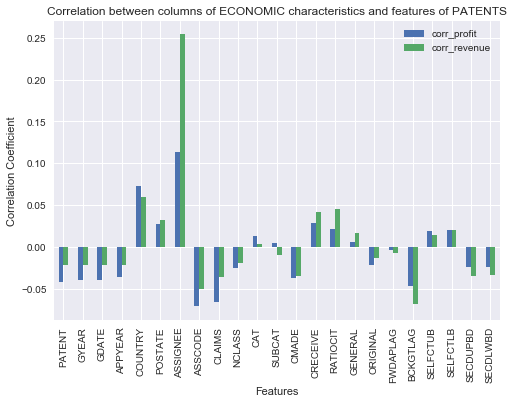

In [138]:
#Preparint the data
X=[]
e_revenue=[]
e_profit=[]
cnames=companies.fortune.unique()
#For each companies
for cname in cnames:
    #Find sub companies names
    c_fortune=fortune[fortune.company==cname]
    #Find sub companies assignee ids
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    #Filter patents info only related to this company
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    #Save it
    X.append(c_relevant)
    #Save the economic characteristics
    e_revenue+=[c_fortune.revenue.iloc[0]]*len(c_relevant)
    e_profit+=[c_fortune.profit.iloc[0]]*len(c_relevant)
#Little bit conversion for sake of further analysis
X=pd.concat(X)
e_revenue=pd.Series(e_revenue)
e_profit=pd.Series(e_profit)

#Exactly same thing as academic
cors_revenue=[]
cors_profit=[]
print("Started correlation calculation")
X = X.fillna({'COUNTRY': 'None','POSTATE': 'None'})
for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
X=X.reset_index().drop('index',axis=1)
for cat in X.columns:
    a=X[cat].corr(e_revenue)
    b=X[cat].corr(e_profit)
    cors_revenue.append(a)
    cors_profit.append(b)
    print(a,b)
    
#Let's see our results
economic_correlations=pd.DataFrame({"features":patents.columns,"corr_revenue":cors_revenue,"corr_profit":cors_profit})
economic_correlations.plot.bar()
plt.xticks( range(23), patents.columns )
plt.ylabel("Correlation Coefficient")
plt.xlabel("Features")
plt.title("Correlation between columns of ECONOMIC characteristics and features of PATENTS")
plt.show()

Obviously, the Assignee id has the highest correlation with revenues and profits. For the features related to time, we can see the same relationship with Academic correlations. Which also can be explained increasing number of patents. However, the inventor's country plays big impact on economic impact, which is different from academics. And also, the number of claims each patent has negative influence on economics, while it was opposite in academics. But we can see interesting results in citation related features. For example, the number of citations made and originality of patent influence negatively in economy. And citations recieved has some degree of correlation (0.045).

### The Comparison between Academic and Economic impacts
Now, since we have evaluated quantative measurements of both academic and economical impacts, let's see their relationships. To do so, we first calculated total number of citations of each company's patents has and the compared it with it's revenue and profits using pair plot and correlation matrix

In [76]:
#Declaring the variables to save the data
a_first=[]
a_second=[]
e_revenue=[]
e_profit=[]
cnames=companies.fortune.unique()
#Again for each company
for cname in cnames:
    c_fortune=fortune[fortune.company==cname]
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    #Find patents info specific to give company
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    #Find Academic values according to the patent ids
    conds=c_relevant["PATENT"].isin(academic.index.values)
    first=pd.Series([academic['first'][indice] if cond else 0 for indice,cond in zip(c_relevant['PATENT'],conds)])
    second=pd.Series([academic['second'][indice] if cond else 0 for indice,cond in zip(c_relevant['PATENT'],conds)])    
    #Then sum up number of citations to find total number of citations of each company's patents
    a_first.append(first.sum())
    a_second.append(second.sum())
    e_revenue.append(c_fortune.revenue.iloc[0])
    e_profit.append(c_fortune.profit.iloc[0])

a_e_impacts=pd.DataFrame({'a_first':a_first,
                          'a_second':a_second,
                          'e_revenue':e_revenue,
                          'e_profit':e_profit})
a_e_impacts.head()

,a_first,a_second,e_profit,e_revenue
0,11241,54435.0,14.8,144.1
1,1074,4166.0,7.0,194.5
2,164,849.0,7.2,257.6
3,2515,9155.0,6.0,214.3
4,332,1525.0,2.0,183.2


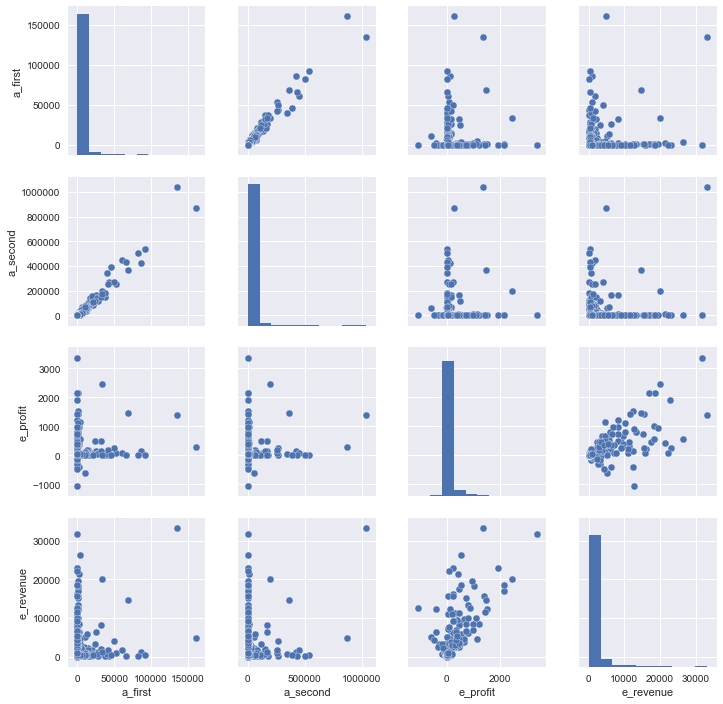

In [77]:
#Now let's make pairplot to see if there is any relationship
import seaborn as sbn
sbn.pairplot(a_e_impacts)
plt.show()

In [80]:
a_e_impacts.corr()

,a_first,a_second,e_profit,e_revenue
a_first,1.000000,0.981324,0.129647,0.152929
a_second,0.981324,1.000000,0.138330,0.178065
e_profit,0.129647,0.138330,1.000000,0.721028
e_revenue,0.152929,0.178065,0.721028,1.000000


The highest relation between academic and economic feature was shown in "second" in ACADEMIC and company's revenues. However, the correlation is still low and it might seem there is no correlation between academic and economic impact. But note that, this analysis is time independent and we have no knowledge about citations of patents that companies already had before 1975.

### The Comparison between Academic and Economic impacts with TIME

In this section, we are dividing the previous analysis on each year. Note that instead of number of citations of each year, we took cumulative sum. The reason is, we also have to take account that given company has already owned previous patents, influencing company's success. And also, we have used column "second" in ACADEMIC dataset for measuring academic impact, since it has considerably large correlation with "first" column.

In [30]:
#Creating Json
cnames=companies.fortune.unique()
d=[]
#Custom functions to help to get data and fill NA values
def filler(dataset,rcolumn,ycolumn,year):
    tmp=dataset[rcolumn][dataset[ycolumn]==year]
    if len(tmp)==0:
        return pd.Series([1])
    else:
        return tmp
def filler_idx(series,year):
    try:
        return series[year]
    except:
        return 0
# For each company
for cname in cnames:
    #Let's find Revenues of each year. 0 if company is not mentioned in fortune list
    c_fortune=fortune[fortune.company==cname]
    revenue=[[int(a),float(filler(c_fortune,'revenue','year',a).iloc[0])] for a in range(1963,2000)]
    
    #As usual, finding patents info only related to given company
    sub_companies_id=companies[companies.fortune==cname].ASSIGNEE
    c_relevant=relevant[relevant['ASSIGNEE'].isin(sub_companies_id)]
    
    #Finding cumulative sum of patents owned by company by year
    tmp=c_relevant.groupby('GYEAR').count()['PATENT']
    tmp=np.cumsum([filler_idx(tmp,y) for y in range(1963,2000)])
    p_cnt=[[int(a),float(b)] for a,b in zip(range(1963,2000),tmp)]
    
    #Finding cumulative sum of patents owned by company by year
    tmp=np.cumsum([int(academic['second'][filler(c_relevant,'PATENT','GYEAR',year)].sum()) for year in range(1963,2000)])
    p_cit=[[int(a),float(b)] for a,b in zip(range(1963,2000),tmp)]
    
    #Finding the most common technological category of each company's patents
    categories=pd.concat([filler(c_relevant,'CAT','GYEAR',year).value_counts() for year in range(1963,2000)],axis=1).fillna(0)
    p_cat=[[int(1963+column),int(np.argmax(categories.ix[:,column]))] for column in range(categories.shape[1])]
    d.append({'c_name':cname,
              'c_revenue':revenue,
              'p_citation':p_cit,
              'p_count':p_cnt,
              'p_category':p_cat
             })
    #Just to monitor if everything is working fine
    if(len(d)%10==0):
        print(100*len(d)/len(cnames))

C:\Users\Bilguun\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1.0416666666666667
2.0833333333333335
3.125
4.166666666666667
5.208333333333333
6.25
7.291666666666667
8.333333333333334
9.375
10.416666666666666
11.458333333333334
12.5
13.541666666666666
14.583333333333334
15.625
16.666666666666668
17.708333333333332
18.75
19.791666666666668
20.833333333333332
21.875
22.916666666666668
23.958333333333332
25.0
26.041666666666668
27.083333333333332
28.125
29.166666666666668
30.208333333333332
31.25
32.291666666666664
33.333333333333336
34.375
35.416666666666664
36.458333333333336
37.5
38.541666666666664
39.583333333333336
40.625
41.666666666666664
42.708333333333336
43.75
44.791666666666664
45.833333333333336
46.875
47.916666666666664
48.958333333333336
50.0
51.041666666666664
52.083333333333336
53.125
54.166666666666664
55.208333333333336
56.25
57.291666666666664
58.333333333333336
59.375
60.416666666666664
61.458333333333336
62.5
63.541666666666664
64.58333333333333
65.625
66.66666666666667
67.70833333333333
68.75
69.79166666666667
70.83333333333333


In [31]:
#Saving our file into json format
import json
djson=json.dumps(d, separators=(',',':'))
f = open('patentImpact.txt','w')
f.write(djson)
f.close()

### To see the visualization of comparison between academic and economic impact over time check our [data story](https://antonino-barbera.github.io/seanbi/)

In [95]:
# Now let's try correlation again
a_e_cors=[]
for year in range(1975-1963,2000-1963):
    c_revs=[]
    c_cits=[]
    for company in d:
        c_revs.append(company["c_revenue"][year][1])
        c_cits.append(company["p_citation"][year][1])
    a_e_cors.append(pd.Series(c_revs).corr(pd.Series(c_cits)))

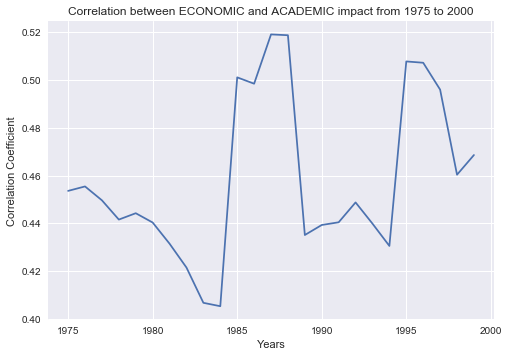

In [139]:
plt.plot(range(1975,2000),a_e_cors)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Years")
plt.title("Correlation between ECONOMIC and ACADEMIC impact from 1975 to 2000")
plt.show()

In general the correlation now is pretty high and showing clear evidence that ACADEMIC impact indead influence on ECONOMY. But interestengly, this graph might be inferring some historical events. For example around early 1980, there was global economical recession happened and it was ended around 1984. And also, through 1989 to 1991, due to inconvenient government policy economical recession happened. However the 1990 to 2000 is considered the golden years of US economy and in 1994 the number of jobs created were peaked. https://en.wikipedia.org/wiki/1990s_United_States_boom, https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States. Even though it is tempting to say that economic and academic relationship is somehow related to nations economical state and policy, further research and expertise are needed.

### Can we predict Academic and Impact?
According to the correlation analysis on these two impact, the features provided to us is not sufficient for building reliable prediction model. But we are trying it anyway. To predict how many citations do patents can have we have used Random Forest Regression for our model and mean absolute error to evaluate our model.

In [141]:
#Useful functions for ML
#Following features are categorical. Thus we are using OneHotEncoder on those features
OHE=OneHotEncoder(categorical_features=[4,5,7,10])
def prepare_x(X):
    #Filling NA values
    cats=['COUNTRY','POSTATE','ASSCODE','CAT']
    X = X.fillna({cats[0]: 'None',
                  cats[1]: 'None'})
    X=X.fillna(-1)
    print("Finished Filling")
    #Coding categorical values
    for cat in ['COUNTRY','POSTATE']:
        X[cat]=LabelEncoder().fit_transform(X[cat])
    X=OHE.fit_transform(X)
    print("Finished Encoding")
    return X
#This function splits the dataset into 80% training, 10% validation and 10% testing
def splitter(length):
    train_i=random.sample(range(0,length),int(length*0.8))
    test_i=list(set(range(0,length))-set(train_i))
    valid_i=random.sample(test_i,int(len(test_i)*0.5))
    test_i=list(set(test_i)-set(valid_i))
    print("Splitted dataset: {tr} - for training, {va} - for validation, {te} - for testing".format(tr=len(train_i),va=len(test_i),te=len(valid_i)))
    return train_i,test_i,valid_i
#This function prepares our data (How wonderful is that!)
def data_preparer(patent,academic,ycols):
    X=prepare_x(patent)
    conds=patent["PATENT"].isin(academic.index.values)
    Y1=np.array([academic[ycols[0]][indice] if cond else 0 for indice,cond in zip(patent['PATENT'],conds)])
    Y2=np.array([academic[ycols[1]][indice] if cond else 0 for indice,cond in zip(patent['PATENT'],conds)])
    return X.tocsr(),Y1,Y2

In [84]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=10, max_depth=100)

train_i,test_i,valid_i=splitter(patents.shape[0])
X,Y1,Y2=data_preparer(patents.drop('CRECEIVE',axis=1),academic,['first','second'])

model.fit(X[train_i,:],Y1[train_i])
abs_errs=np.absolute(Y1[test_i]-model.predict(X[test_i,:]))
print("Mean Absolute Error")
print(pd.Series(abs_errs).mean())
print("--------------------------------------------")
print("Mean value of citations recieved")
print(pd.Series(Y1).mean())

Mean Absolute Error
1.0685686729846473
--------------------------------------------
Mean value of citations recieved
4.779235903009725
